In [31]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

import boto3
# import s3fs
# import fastparquet
# import awswrangler as wr
import os

# import pyarrow.parquet as pq
# import pyarrow as pa

import requests
import json
from io import BytesIO
from pandas.tseries.offsets import BDay

import math

In [32]:
returns = pd.read_csv('ibex_historical_returns.csv',index_col='date')
returns.index = pd.to_datetime(returns.index)
returns.head()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-11,NaN,NaN,NaN,NaN,NaN,0.038238,NaN,NaN,NaN,-0.001007,...,NaN,NaN,NaN,NaN,0.005841,NaN,NaN,NaN,NaN,0.009776
1993-08-12,NaN,NaN,NaN,NaN,NaN,0.039881,NaN,NaN,NaN,0.024588,...,NaN,NaN,NaN,NaN,0.022995,NaN,NaN,NaN,NaN,0.017845
1993-08-13,NaN,NaN,NaN,NaN,NaN,0.017449,NaN,NaN,NaN,0.030090,...,NaN,NaN,NaN,NaN,0.002876,NaN,NaN,NaN,NaN,0.008291
1993-08-16,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-0.001881,...,NaN,NaN,NaN,NaN,0.002733,NaN,NaN,NaN,NaN,0.000385
1993-08-17,NaN,NaN,NaN,NaN,NaN,0.000831,NaN,NaN,NaN,0.023395,...,NaN,NaN,NaN,NaN,0.025183,NaN,NaN,NaN,NaN,0.016909


In [33]:
t_bill_files = [filename for filename in os.listdir('./Datos TFM') if filename.startswith("United States 3-Month Bond Yield")]
t_bill_data = pd.DataFrame()
for f in t_bill_files:
    file_path = './Datos TFM/'+f
    file = pd.read_csv(file_path)
    t_bill_data = pd.concat([t_bill_data,file],axis=0)
t_bill_data.index = pd.to_datetime(t_bill_data.Date)
t_bill_data.drop('Date',axis=1,inplace=True)
t_bill_data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2023-07-25,5.436,5.432,5.439,5.426,0.34%
2023-07-24,5.418,5.453,5.486,5.418,-0.11%
2023-07-21,5.424,5.445,5.469,5.411,0.15%
2023-07-20,5.416,5.448,5.503,5.409,0.07%
2023-07-19,5.412,5.452,5.452,5.409,0.00%


In [34]:
def locate_in_df(df, value):
    a = df.to_numpy()
    row = np.where(a == value)[0][0]
    col = np.where(a == value)[1][0]
    return row, col
locate_in_df(sharpe_ratio,sharpe_ratio.min().min()),sharpe_ratio.min().min()

((3514, 35), -13.325416759985345)

In [35]:
# DEFINIMOS UNA CANTIDAD DE DIAS PARA LA VENTANA DE CALCULO DE LOS RETORNOS
DIAS = 90
ACTIVOS = 10

adjusted_returns = returns.apply(lambda x: x.fillna(abs(x.min())*-2), axis=1)
# DEFINIMOS NUESTRA TASA LIBRE DE RIESGO A TRAVÉS DE LOS VALORES DE LA TASA T-BILLS DE 3 MESES
risk_free_rate = t_bill_data['Price']/100
risk_free_rate = risk_free_rate.sort_index()
adjusted_returns['risk_free_rate'] = risk_free_rate.loc[returns.index[0]:]
adjusted_returns['risk_free_rate'] = adjusted_returns['risk_free_rate'].fillna(method='ffill')
# AGREGAMOS LA OPCIÓN DE NO INVERTIR EN NINGUN ACTIVO COMO UNA COLUMNA CON RETORNO CERO
# returns['cash'] = 0

# CALCULAMOS LA SUMA DE RETORNOS CON ESA VENTANA DE DIAS DEFINIDA
adjusted_returns = (adjusted_returns.iloc[:,:-2].transpose() - adjusted_returns['risk_free_rate']).transpose()
adjusted_period_returns_mean = adjusted_returns.rolling(DIAS, min_periods=DIAS).mean()
adjusted_period_returns_std = adjusted_returns.rolling(DIAS, min_periods=DIAS).std()

sharpe_ratio = adjusted_period_returns_mean / adjusted_period_returns_std
# sharpe_ratio.drop('risk_free_rate',axis=1)
sharpe_ratio.loc[sharpe_ratio.index[DIAS:]]

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-12-20,-2.396984,-2.396984,-2.396984,-2.396984,-2.396984,-2.240247,-2.396984,-2.396984,-2.396984,-2.063562,...,-2.396984,-2.396984,-2.396984,-2.396984,-2.396984,-1.585784,-2.396984,-2.396984,-2.396984,-2.396984
1993-12-21,-2.420337,-2.420337,-2.420337,-2.420337,-2.420337,-2.377232,-2.420337,-2.420337,-2.420337,-2.117797,...,-2.420337,-2.420337,-2.420337,-2.420337,-2.420337,-1.613700,-2.420337,-2.420337,-2.420337,-2.420337
1993-12-22,-2.441737,-2.441737,-2.441737,-2.441737,-2.441737,-2.390661,-2.441737,-2.441737,-2.441737,-2.144366,...,-2.441737,-2.441737,-2.441737,-2.441737,-2.441737,-1.609074,-2.441737,-2.441737,-2.441737,-2.441737
1993-12-23,-2.630530,-2.630530,-2.630530,-2.630530,-2.630530,-2.273886,-2.630530,-2.630530,-2.630530,-2.005967,...,-2.630530,-2.630530,-2.630530,-2.630530,-2.630530,-1.612524,-2.630530,-2.630530,-2.630530,-2.630530
1993-12-27,-2.630692,-2.630692,-2.630692,-2.630692,-2.630692,-2.048608,-2.630692,-2.630692,-2.630692,-1.900063,...,-2.630692,-2.630692,-2.630692,-2.630692,-2.630692,-1.637805,-2.630692,-2.630692,-2.630692,-2.630692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,-3.032902,-3.032902,-3.032902,-3.032902,-4.439225,-3.032902,-3.601336,-4.213277,-3.032902,-3.032902,...,-3.032902,-3.032902,-3.032902,-3.032902,-3.032902,-3.032902,-3.032902,-3.032902,-3.032902,-3.032902
2023-08-07,-3.079093,-3.079093,-3.079093,-3.079093,-4.596245,-3.079093,-3.615628,-4.365863,-3.079093,-3.079093,...,-3.079093,-3.079093,-3.079093,-3.079093,-3.079093,-3.079093,-3.079093,-3.079093,-3.079093,-3.079093
2023-08-08,-3.122746,-3.122746,-3.122746,-3.122746,-4.686822,-3.122746,-3.670260,-4.427830,-3.122746,-3.122746,...,-3.122746,-3.122746,-3.122746,-3.122746,-3.122746,-3.122746,-3.122746,-3.122746,-3.122746,-3.122746


In [112]:
sharpe_ratio.loc[sharpe_ratio.index[DIAS:]].rank(axis=1, numeric_only=True, method='max', ascending=False)

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-12-20,93.0,93.0,93.0,93.0,93.0,9.0,93.0,93.0,93.0,5.0,...,93.0,93.0,93.0,93.0,93.0,2.0,93.0,93.0,93.0,93.0
1993-12-21,94.0,94.0,94.0,94.0,94.0,9.0,94.0,94.0,94.0,7.0,...,94.0,94.0,94.0,94.0,94.0,3.0,94.0,94.0,94.0,94.0
1993-12-22,94.0,94.0,94.0,94.0,94.0,9.0,94.0,94.0,94.0,7.0,...,94.0,94.0,94.0,94.0,94.0,3.0,94.0,94.0,94.0,94.0
1993-12-23,94.0,94.0,94.0,94.0,94.0,9.0,94.0,94.0,94.0,4.0,...,94.0,94.0,94.0,94.0,94.0,3.0,94.0,94.0,94.0,94.0
1993-12-27,94.0,94.0,94.0,94.0,94.0,5.0,94.0,94.0,94.0,4.0,...,94.0,94.0,94.0,94.0,94.0,2.0,94.0,94.0,94.0,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,37.0,59.0,25.0,17.0,88.0,39.0,80.0,85.0,29.0,37.0,...,61.0,41.0,20.0,37.0,58.0,37.0,50.0,45.0,32.0,58.0
2023-08-07,32.0,57.0,23.0,15.0,90.0,37.0,79.0,86.0,26.0,35.0,...,59.0,39.0,18.0,35.0,53.0,35.0,48.0,43.0,30.0,56.0
2023-08-08,34.0,56.0,22.0,14.0,89.0,36.0,78.0,86.0,26.0,32.0,...,58.0,38.0,17.0,32.0,55.0,32.0,47.0,42.0,29.0,55.0


In [114]:
ranking = sharpe_ratio.loc[sharpe_ratio.index[DIAS:]].rank(axis=1, numeric_only=True, method='max',ascending=False)
# ranking = (sharpe_ratio.loc[sharpe_ratio.index[10:-4]] - sharpe_ratio.loc[sharpe_ratio.index[10:-4]].mean())/sharpe_ratio.loc[sharpe_ratio.index[10:-4]].std()
# ranking = sharpe_ratio.loc[sharpe_ratio.index[DIAS:]]#.fillna(sharpe_ratio.min().min())
# ranking = ((ranking - ranking.mean()) / ranking.std())
ranking = (ranking - ranking.max())/(ranking.max() - ranking.min()) - 0.5
# ranking = ranking.fillna(-1)
ranking

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-12-20,-0.510753,-0.510753,-0.510989,-0.510870,-0.510753,-1.413978,-0.510753,-0.510870,-0.510753,-1.456989,...,-0.511236,-0.510753,-0.510753,-0.510753,-0.510870,-1.489130,-0.510753,-0.510753,-0.510753,-0.510753
1993-12-21,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-1.413978,-0.500000,-0.500000,-0.500000,-1.435484,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-1.478261,-0.500000,-0.500000,-0.500000,-0.500000
1993-12-22,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-1.413978,-0.500000,-0.500000,-0.500000,-1.435484,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-1.478261,-0.500000,-0.500000,-0.500000,-0.500000
1993-12-23,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-1.413978,-0.500000,-0.500000,-0.500000,-1.467742,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-1.478261,-0.500000,-0.500000,-0.500000,-0.500000
1993-12-27,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-1.456989,-0.500000,-0.500000,-0.500000,-1.467742,...,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-1.489130,-0.500000,-0.500000,-0.500000,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,-1.112903,-0.876344,-1.258242,-1.336957,-0.564516,-1.091398,-0.650538,-0.597826,-1.198925,-1.112903,...,-0.870787,-1.069892,-1.295699,-1.112903,-0.891304,-1.108696,-0.973118,-1.026882,-1.166667,-0.887097
2023-08-07,-1.166667,-0.897849,-1.280220,-1.358696,-0.543011,-1.112903,-0.661290,-0.586957,-1.231183,-1.134409,...,-0.893258,-1.091398,-1.317204,-1.134409,-0.945652,-1.130435,-0.994624,-1.048387,-1.188172,-0.908602
2023-08-08,-1.145161,-0.908602,-1.291209,-1.369565,-0.553763,-1.123656,-0.672043,-0.586957,-1.231183,-1.166667,...,-0.904494,-1.102151,-1.327957,-1.166667,-0.923913,-1.163043,-1.005376,-1.059140,-1.198925,-0.919355


In [37]:
ranking = ranking.dropna()

In [115]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout, Reshape
from keras.optimizers import Adam
from keras.regularizers import L2
from keras.models import Sequential
import tensorflow_ranking as tfr
from keras.callbacks import EarlyStopping

In [116]:
test_split = math.floor(returns.shape[0]*0.7)
val_split = math.floor(returns.shape[0]*0.9)
X = adjusted_returns.iloc[:ranking.shape[0]:,]#.fillna(returns.min().min() * 2,)

data = np.zeros((X.shape[0]-DIAS,DIAS,X.shape[1]))
for i in range(X.shape[0]-DIAS):
    data[i] = X[i:i+DIAS]

In [117]:
# ranking = tf.keras.utils.to_categorical(ranking-1, num_classes = len(ranking.columns))

In [118]:
window = 30
X_train = data[:test_split]
X_test = data[test_split:val_split]
X_val = data[val_split:-window]
y_train = ranking[DIAS+window:test_split+DIAS+window]
y_test = ranking[test_split+DIAS+window:val_split+DIAS+window]
y_val = ranking[val_split+DIAS+window:]

In [119]:
from keras import backend as K
hp_top = 10
hp_incremento_top = 3
def top_is_target(y_true, y_pred):
  num_samples = K.shape(y_true)[0]

  w = K.arange(94, dtype='float32')
  w = K.reverse(w, axes=0) + 0.0001

  w = tf.where(K.arange(94) < hp_top, w * hp_incremento_top, w)
  # Replicar w a lo largo del eje 0 (batch)
  #w = K.repeat_elements(K.expand_dims(w, 0), num_samples, axis=0)
  w = tf.tile(K.expand_dims(w, 0), [num_samples, 1])

  # Calcular la pérdida
  r = K.cast(y_true, 'float32')
  r_pred = K.cast(y_pred, 'float32')

  return K.mean(w * K.square(r - r_pred), axis=-1)

In [268]:
model = Sequential()

model.add(Dense(6, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2],), kernel_regularizer=L2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='tanh', kernel_regularizer=L2(0.02)))
model.add(Dropout(0.5))
# model.add(Dense(32,activation='relu',kernel_regularizer=L2(0.002)))
# model.add(Dropout(0.5))
# model.add(Dense(16,activation='relu',kernel_regularizer=L2(0.002)))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(data.shape[2],activation='tanh'))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 90, 6)             570       
                                                                 
 dropout_22 (Dropout)        (None, 90, 6)             0         
                                                                 
 dense_36 (Dense)            (None, 90, 3)             21        
                                                                 
 dropout_23 (Dropout)        (None, 90, 3)             0         
                                                                 
 flatten_13 (Flatten)        (None, 270)               0         
                                                                 
 dense_37 (Dense)            (None, 94)                25474     
                                                                 
Total params: 26065 (101.82 KB)
Trainable params: 260

In [269]:
earlystopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

In [270]:
batch_size = 32
h = model.fit(
      X_train, y_train,
      epochs=len(X_train) // batch_size + 1,
      validation_data = (X_test, y_test),
    #   callbacks = [earlystopping],
      shuffle=False,
      verbose=True
          )

Epoch 1/167
167/167 [==============================] - 6s 6ms/step - loss: 0.3116 - val_loss: 0.1935
Epoch 2/167
167/167 [==============================] - 1s 5ms/step - loss: 0.1561 - val_loss: 0.1312
Epoch 3/167
167/167 [==============================] - 1s 5ms/step - loss: 0.1144 - val_loss: 0.1110
Epoch 4/167
167/167 [==============================] - 1s 4ms/step - loss: 0.1004 - val_loss: 0.1018
Epoch 5/167
167/167 [==============================] - 1s 4ms/step - loss: 0.0937 - val_loss: 0.0977
Epoch 6/167
167/167 [==============================] - 1s 4ms/step - loss: 0.0911 - val_loss: 0.0983
Epoch 7/167
167/167 [==============================] - 1s 4ms/step - loss: 0.0902 - val_loss: 0.0982
Epoch 8/167
167/167 [==============================] - 1s 4ms/step - loss: 0.0900 - val_loss: 0.0974
Epoch 9/167
167/167 [==============================] - 1s 4ms/step - loss: 0.0893 - val_loss: 0.0966
Epoch 10/167
167/167 [==============================] - 1s 5ms/step - loss: 0.0886 - val_lo

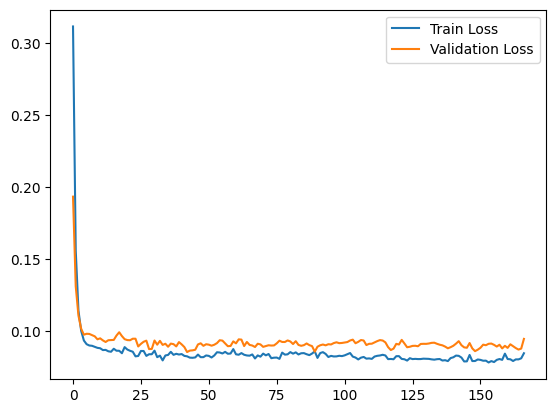

In [271]:
plt.plot(h.history['loss'],label='Train Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.legend();

In [272]:
y_pred = model.evaluate(X_val,y_val)
y_pred

18/18 [==============================] - 0s 2ms/step - loss: 0.1089


0.10885337740182877

In [273]:
y_pred = model.predict(X_val)

18/18 [==============================] - 0s 2ms/step


In [274]:
y_pred = pd.DataFrame(y_pred, columns=y_val.columns)

In [275]:
i = 150
index = y_val.iloc[i].name

In [276]:
indexes = list(returns.loc[index].dropna().index[:-2])

In [277]:
ranking_real = np.argsort(np.argsort(-y_val.iloc[i][indexes]))
ranking_pred = np.argsort(np.argsort(-y_pred.iloc[i][indexes]))

In [278]:
ranking_real_ordenado = ranking_real.iloc[np.where(ranking_real<10)].sort_values(ascending=True)
ranking_real_ordenado

ROVI     0
CLNX     1
ALM      2
GRF      3
PHM      4
FDR      5
SGRE     6
COL_1    7
ELE_1    8
IBE      9
Name: 2022-01-19 00:00:00, dtype: int64

In [279]:
ranking_pred_ordenado = ranking_pred.iloc[np.where(ranking_pred<10)].sort_values(ascending=True)
ranking_pred_ordenado

CIE      0
ANA_2    1
PHM      2
MEL      3
FDR      4
ALM      5
SLR      6
COL_1    7
SGRE     8
CLNX     9
Name: 150, dtype: int64

In [280]:
ranking_pred_ordenado,ranking_real_ordenado

(CIE      0
 ANA_2    1
 PHM      2
 MEL      3
 FDR      4
 ALM      5
 SLR      6
 COL_1    7
 SGRE     8
 CLNX     9
 Name: 150, dtype: int64,
 ROVI     0
 CLNX     1
 ALM      2
 GRF      3
 PHM      4
 FDR      5
 SGRE     6
 COL_1    7
 ELE_1    8
 IBE      9
 Name: 2022-01-19 00:00:00, dtype: int64)

In [281]:
error = np.argsort(np.argsort(-ranking_real)) - np.argsort(np.argsort(-ranking_pred))
error[(error >=-5) & (error <=5) & (error.index.isin(ranking_pred_ordenado.index))]

ALM      3
COL_1    0
FDR     -1
PHM     -2
SGRE     2
dtype: int64

In [282]:
error[ranking_pred_ordenado.index]

CIE     -30
ANA_2   -13
PHM      -2
MEL     -23
FDR      -1
ALM       3
SLR      -9
COL_1     0
SGRE      2
CLNX      8
dtype: int64